# Fetching tweets from Twitter API using Tweepy

Twitter API V2 Official Documentation: Get to know more about parameters <br>
[Link](https://github.com/twitterdev/getting-started-with-the-twitter-api-v2-for-academic-research/blob/main/modules/5-how-to-write-search-queries.md)

In [1]:
# import libraries 
import matplotlib.pyplot as plt 
from twarc import Twarc2,expansions 
import tweepy 
import configparser
import time
import pandas as pd

## Authentication 

### 1. Read Configs 

By using `configparser` library, the authorization files can be stored seperatly without hurting the availibility of sharing working files. 

In [2]:
config = configparser.ConfigParser(interpolation=None)
config. read('config.ini')

api_key = config['twitter']['api_key']
api_key_secret = config['twitter']['api_key_secret']
access_token = config['twitter']['access_token']
access_token_secret = config['twitter']['access_token_secret']
bearer_token = config['twitter']['bearer_token']

### 2. Authenticate 
Authenticate the account/app to the Twitter API. 

In [3]:
from multiprocessing.connection import wait


auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)

# create the API instance
twarc2_client = tweepy.API(auth)

# or use Tweepy 
client = tweepy.Client(bearer_token = bearer_token, wait_on_rate_limit= True)

## Fetching Data

### 1. user search

In [4]:
user = 'Nike'

# fetch the last 100 tweets 
limit = 300 

# prevent to reach the cap 
tweets = tweepy.Cursor(twarc2_client.user_timeline, 
              screen_name = user, 
              count = 200,
              tweet_mode = 'extended').items(limit)

# tweets = api.user_timeline(
#                             screen_name = user, 
#                             cont = limit,
#                             tweet_mode = 'extended', # prevent the API to truncate only 140 characters
#                             ) 

# create DataFrame
columns = ['user_id','user_location','user_name','text']
data = []

for tweet in tweets: 
    # the tab provides multiple parameter selection 
    data.append([tweet.user.id, 
                tweet.user.location, 
                tweet.user.screen_name, 
                tweet.full_text])

df1 = pd.DataFrame(data, columns = columns)
df1.head()

,user_id,user_location,user_name,text
0,415859364,"Beaverton, Oregon",Nike,@Skyblues2i C'est super dans ce cas ! Très bon...
1,415859364,"Beaverton, Oregon",Nike,"@Moha_lassel Salut, nous sommes navrés de voir..."
2,415859364,"Beaverton, Oregon",Nike,"@anissa_zaraoui Bonjour, peux-tu venir en DM e..."
3,415859364,"Beaverton, Oregon",Nike,"@Skyblues2i Bonjour, peux-tu venir en DM et no..."
4,415859364,"Beaverton, Oregon",Nike,@deejaysoulrebel Tell your son Nike says to ke...


### 2. keywords or hashtags search 

In [5]:
keywords = 'sneakers'
limit = 500 # why must add limit? 

tweets_keyword_search = tweepy.Cursor(
              twarc2_client.search_tweets, 
              q= keywords, 
              count = 100,
              tweet_mode = 'extended').items(limit)

# create DataFrame
columns = ['author_id','author_name','created_time','location','text']
data = []

for tweet in tweets_keyword_search: 
    data.append([tweet.author.id, 
                 tweet.author.name,
                 # time can be more granualler depending on the need 
                 tweet.created_at,
                 tweet.user.location, 
                 tweet.full_text])

df2 = pd.DataFrame(data, columns = columns)
df2.head()

,author_id,author_name,created_time,location,text
0,1279230639544373248,magnito,2022-10-10 14:54:33+00:00,,RT @zenmagafrica: Sneakers and Tracksuits on S...
1,497299265,Twini,2022-10-10 14:54:28+00:00,,RT @martinicandoll: Les sneakers 😭 je trouve ç...
2,1569548409719394304,CozeUnisex,2022-10-10 14:54:21+00:00,,RT @zenmagafrica: Sneakers and Tracksuits on S...
3,2879236727,RA ⚽,2022-10-10 14:54:17+00:00,,RT @zenmagafrica: Sneakers and Tracksuits on S...
4,1314504233207525376,Susmoy Hredoy 🔶,2022-10-10 14:54:14+00:00,"Mymensingh, Bangladesh",RT @amazyio: 🚀 GIVEAWAY 100+ NFT SNEAKERS AMAZ...


### 3. Full-Archive Search
Get more than 500 Tweets at a time using `paginator`, which will automately go for the next page.

[Reference](https://www.youtube.com/watch?v=rQEsIs9LERM)

In [6]:
# set query, parameters changable 
input_query = 'sneakers -is:retweet lang:en place_country:US'

def full_archive_search(input_query): 
    """
    Function for API query with input parameters
    ----------------------
    Input: query 
    Output: API request result

    """
    result = []

    for response in tweepy.Paginator(client.search_all_tweets, 
                                    # doesn't include the retweet
                                    query = input_query,
                                    user_fields = ['username', 'public_metrics', 'description', 'location'],
                                    tweet_fields = ['created_at', 'geo', 'public_metrics', 'text'],
                                    expansions = 'author_id',
                                    start_time = '2022-08-01T00:00:00Z',
                                    end_time = '2022-09-30T23:59:59Z',
                                    max_results=500, limit = 20):
    # the `search_all_tweets` has per second limit, therefore should wait for a second before the code progresses                              
        time.sleep(1)
        result.append(response)

    return result

tweepy_query = full_archive_search(input_query)

In [7]:
def full_archive_search_df(tweepy_query):

    """
    Function for reformat the function the query into dataframe.
    --------------------
    Input: the tweepy query result 
    Output: pandas dataframe format of query result

    """
    result = []
    user_dict = {}

    # loop through each response object
    for response in tweepy_query:
        
        # take all of the users, and put them into a dictionary of dictionaries with the info we want to keep
        for user in response.includes['users']:
            user_dict[user.id] = {'username': user.username, 
                                'followers': user.public_metrics['followers_count'],
                                'tweets': user.public_metrics['tweet_count'],
                                'description': user.description,
                                'location': user.location
                                }

        # for each tweet, find the author information                        
        for tweet in response.data:
            author_info = user_dict[tweet.author_id]

            # put all of the information we want to keep in a single dictionary for each tweet 
            result.append({'author_id': tweet.author_id, 
                        'username': author_info['username'],
                        'author_followers': author_info['followers'],
                        'author_tweets': author_info['tweets'],
                        'author_description': author_info['description'],
                        'author_location': author_info['location'],
                        'text': tweet.text,
                        'created_at': tweet.created_at,
                        'retweets': tweet.public_metrics['retweet_count'],
                        'replies': tweet.public_metrics['reply_count'],
                        'likes': tweet.public_metrics['like_count'],
                        'quote_count': tweet.public_metrics['quote_count']
                        })

    tweepy_query_df = pd.DataFrame(result)
    return tweepy_query_df

sneakers_df = full_archive_search_df(tweepy_query)

In [8]:
sneakers_df.shape

(2786, 12)

In [9]:
sneakers_df.head()

,author_id,username,author_followers,author_tweets,author_description,author_location,text,created_at,retweets,replies,likes,quote_count
0,1493612427304488965,1KHABYS,128,2236,Be ¥a $elf or Bring ¥a $hooters! 👀🎮 BYS LLC™️ ...,Around da corner⭐️,Privileged never paid over box price for sneakers,2022-09-30 23:28:41+00:00,0,0,0,0
1,29560488,CarrieMae_,344,12287,"the devil works hard, kris jenner works harder","Brooklyn, NY",Trying to have a peaceful evening and at the r...,2022-09-30 23:21:03+00:00,0,0,0,0
2,22680919,MattHalfhill,13052,540,Founder + CEO of @nicekicks. Product of Fresno.,"Austin, TX",Drop sneakers at a job fair if you don’t want ...,2022-09-30 23:13:22+00:00,111,45,1196,32
3,997270922976481282,JEFF_SON_334,614,3830,"Husband, Father to a son ,COOL MF in General U...","Montgomery, AL",I hate the fact that Puma ain’t got no sneaker...,2022-09-30 22:36:38+00:00,0,0,0,0
4,101915799,kwamemorgan,847,25453,Follow my IG : @Kwamemorgan,"ÜT: 38.899236,-76.797741",@1_Bundles You know my lil buddies gone geek t...,2022-09-30 22:33:35+00:00,0,1,0,0


### 4. Full-Archive Search for brands 

#### 4.1 Nike

In [10]:
# Nike 
input_query = 'nike -is:retweet lang:en place_country:US'
nike_query = full_archive_search(input_query)
nike_df = full_archive_search_df(nike_query)

In [11]:
print(nike_df.shape)
nike_df.head()

(7877, 12)


,author_id,username,author_followers,author_tweets,author_description,author_location,text,created_at,retweets,replies,likes,quote_count
0,87144412,GarrettKGray,376,12086,Land Economist & Economic Development Speciali...,"Coos Bay, OR",@ShaneDaleAZ Totally. The Nike uniforms since ...,2022-09-30 23:46:59+00:00,0,0,0,0
1,492330913,LockDown_Lopes,470,97876,"@nicekicks, sports, & memes | University of Ar...","Scottsdale, AZ",Hats off to Tom Sachs and the marketing team a...,2022-09-30 23:43:45+00:00,0,0,0,0
2,37706001,RyanGensler,6683,13623,315 Born and Raised: Assistant Basketball Coac...,"Champaign, IL",The look on @makiracook face! 😂 \n\nThanks @Ni...,2022-09-30 23:38:15+00:00,1,1,27,0
3,17417435,ShellzBoss,564,22093,"#TeamLibra #TeamLesbian Hibernating, should be...","Maryland, Michigan",Check out my new pickup from Nike⁠ SNKRS: http...,2022-09-30 23:35:28+00:00,0,1,0,0
4,853714067692806144,DJKingJam,395,3774,Jordan Shoe collector || DJ Jamez || Music Pro...,"Seattle, WA",@jameslfreelance @Jumpman23 @Nike @nikestore O...,2022-09-30 23:15:57+00:00,0,0,2,0


In [12]:
nike_df['text'][0]

'@ShaneDaleAZ Totally. The Nike uniforms since have replaced a distinguished/identifiable look to enhance their own brand at the expense of Arizona.'

### 4.2 New Balance

In [13]:
# newbalance 
input_query = 'newbalance -is:retweet lang:en place_country:US'
nb_query = full_archive_search(input_query)
nb_df = full_archive_search_df(nb_query)

In [14]:
print(nb_df.shape)
nb_df['text'][200]

(239, 12)


'The sun drained me, today. But we came out and I got it done. #newbalance #runinrabbit #suunto9 @ Joe B Freeman Park https://t.co/Z6EhN0eLG6'

### 4.3 Adidas

In [15]:
# adidas  
input_query = 'adidas -is:retweet lang:en place_country:US'
adidas_query = full_archive_search(input_query)
adidas_df = full_archive_search_df(adidas_query)

In [16]:
print(adidas_df.shape)
adidas_df['text'][178]

(2347, 12)


'You don’t need adidas or a zebra to see my stripes @Mr_Camron 🌪🔥🔥🔥'

### 4.4 Converse 

In [17]:
# converse  
input_query = 'converse -is:retweet lang:en place_country:US'
converse_query = full_archive_search(input_query)
converse_df = full_archive_search_df(converse_query)

In [18]:
print(converse_df.shape)
converse_df['text'][169]

(942, 12)


'@carizmen @Converse Me encantaron ❤️'

### 4.5 Reebok

In [19]:
# reebok  
input_query = 'reebok -is:retweet lang:en place_country:US'
reebok_query = full_archive_search(input_query)
reebok_df = full_archive_search_df(reebok_query)

In [20]:
print(reebok_df.shape)
reebok_df['text'][152]

(243, 12)


'@chinababee Well if you’re only talking about one song vs the other then sure, but lets talk about his Reebok collection though, his new crackhead appearance, his new bitch, him continuously claiming he’s #1 worldwide when we all know who is lmaooo I can keep going.'

In [21]:
len(reebok_df)

243

### 4.6 Combine the info 

In [22]:
# text count of each brand 
d = {'brand':['Nike','New Balance','Adidas','Converse','Reebok'],
     'count':[len(nike_df), len(nb_df), len(adidas_df),len(converse_df),len(reebok_df)]}

brand_text_count = pd.DataFrame(columns=['brand','count'], data = d)

brand_text_count.sort_values(by = ['count'],ascending = False)

,brand,count
0,Nike,7877
2,Adidas,2347
3,Converse,942
4,Reebok,243
1,New Balance,239


In [50]:
# full dataset 
df = pd.concat([nike_df, adidas_df, nb_df, converse_df, reebok_df], axis = 0 )
df.shape

(11648, 12)

In [51]:
# export the five brands twitter data in the data folder 
os.chdir('C:\\Users\\hs324\\OneDrive\\Desktop\\Class_Files\\06_2022Fall\\04_Practicum\\Quantilope_Core\\data')

df.to_csv('five_brands_text.csv',index=False)

# Sentiment Analysis on User Text 
Francese use Textblob for polarity

In [27]:
# for text processing and cleaning 
import re
import nltk 
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import string 
string.punctuation

# remove warnings 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

# for sentiment analysis 
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from wordcloud import WordCloud,STOPWORDS, ImageColorGenerator

# for topic modeling using LDA 
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel 

# plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as ex
from plotly.subplots import make_subplots
import pyLDAvis
# import pyLDAvis.gensim 
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

print('✔️ Libraries Imported!')

✔️ Libraries Imported!


c:\Users\hs324\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## NLTK with Vader

### 1.1 Understand the Raw Dataset 

In [75]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
plt.style.use('ggplot')
import nltk 

In [54]:
# Load data into dataframe, skip the error lines
from operator import index


df = pd.read_csv('..\\data\\five_brands_text.csv')
df.shape

(11648, 12)

In [72]:
text_raw = df['text']
text_raw

0        @ShaneDaleAZ Totally. The Nike uniforms since ...
1        Hats off to Tom Sachs and the marketing team a...
2        The look on @makiracook face! 😂 \n\nThanks @Ni...
3        Check out my new pickup from Nike⁠ SNKRS: http...
4        @jameslfreelance @Jumpman23 @Nike @nikestore O...
                               ...                        
11643    Armpit musty, Reebok crusty https://t.co/KjJ3z...
11644    @DoubleOhNegatve I believe that was the Reebok...
11645    If you ever find yourself talking shit on will...
11646    Think the 4,5 shoes gon be Reebok, Doc’s and s...
11647    🔥 It is back to school shopping time and what ...
Name: text, Length: 11648, dtype: object

### 1.2 Text Preprocessing 

As __*lemmatization*__ will return the words to its original form based on its semantic meaning, while __*stemming*__ basically will chop off the suffix and sometimes loose information. <br><br>
Although that stemming being a rule-based approach, it runs faster than lemmatization, considering our corpuses size isn't too big and the more accurate nature of the canonical dictionary-based approach of lemma, we'll use lemmatization in this case. 

In [64]:
def clean_text_lemma(var):
    """
    Function for text preprocessing with Lemmatizing with POS tag.
    """
    # remove the stop words 
    sw = set(stopwords.words('english'))

    # lemmatizing and using grouped word chuncks 
    lemmatizer = WordNetLemmatizer()
    wordnet_map = {"N": wordnet.NOUN,"V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
    
    # tokenize the word using nltk  
    my_text = nltk.word_tokenize(var)
    
    # remove not english characters, lower case and split the text 
    my_text = re.sub('[^A-Za-z0-9]+', " ", var).lower().strip() 

    # remove the stop words 
    my_text = [word for word in my_text.split() if word not in sw]

    # lemmatizing 
    pos_tagged_text = nltk.pos_tag(my_text) 
    my_text = " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

    # removal of URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    my_text = url_pattern.sub(r'', my_text)

    # removal of HTML Tags
    my_text = BeautifulSoup(my_text, "lxml").text

    # convert the text to list as the vectorized words  
    my_text = my_text.split(" ")

    return my_text

In [73]:
# try the data in small bulk 
test = text_raw[10:20]
test

10    Whatcha think of these? #Leggings #scrunchy #F...
11    Sheesh. These Dunks go crazy @nike #justdoit h...
12    I'm at Nike Soho - @nikenyc in New York https:...
13    NEW KICKS 👀♥️😍🫠💸\n#Nike #AF1 #airforce1 @ Orla...
14    “Good Times” last night at City Parks Foundati...
15    Fuck y’all 10% off Nike because it’s clearly f...
16    @unionlosangeles Passport Pack is ready to shi...
17    I got my eyes on the Blue Nike Sacai. Does any...
18    I need to buy more Nike React Phantom Run Flyk...
19    This announcement cost @nike $20b today\n\n@gh...
Name: text, dtype: object

In [82]:
# snippet of the text preprocessing results
test.apply(lambda text: clean_text_lemma(text))

10    [whatcha, think, legging, scrunchy, fridayvibe...
11    [sheesh, dunk, go, crazy, nike, justdoit, http...
12    [nike, soho, nikenyc, new, york, http, co, ju0...
13    [new, kick, nike, af1, airforce1, orlando, flo...
14    [good, time, last, night, city, park, foundati...
15    [fuck, 10, nike, clearly, fuck, birthday, bull...
16    [unionlosangeles, passport, pack, ready, ship,...
17    [get, eye, blue, nike, sacai, anyone, pair, co...
18    [need, buy, nike, react, phantom, run, flyknit...
19    [announcement, cost, nike, 20b, today, ghst, i...
Name: text, dtype: object

In [97]:
# implement on the whole text files 
text_clean_object = text_raw.apply(lambda text: clean_text_lemma(text))

In [113]:
len(text_clean_object)

11648

In [128]:
# convert the clean dataset into dataframe 
text_clean = pd.DataFrame(text_clean_object)
text_clean['Id'] = [num for num in range(0,len(text_clean_object))]
text_clean.head()

,text,Id
0,"[shanedaleaz, totally, nike, uniform, since, r...",0
1,"[hat, tom, sachs, marketing, team, nike, relea...",1
2,"[look, makiracook, face, thanks, nike, http, c...",2
3,"[check, new, pickup, nike, snkrs, http, co, ri...",3
4,"[jameslfreelance, jumpman23, nike, nikestore, ...",4


In [132]:
# maybe try to put the raw data in frist 
text_raw_df = pd.DataFrame(text_raw)
text_raw_df['Id'] = [num for num in range(0,len(text_raw_df))]
text_raw_df.head()

,text,Id
0,@ShaneDaleAZ Totally. The Nike uniforms since ...,0
1,Hats off to Tom Sachs and the marketing team a...,1
2,The look on @makiracook face! 😂 \n\nThanks @Ni...,2
3,Check out my new pickup from Nike⁠ SNKRS: http...,3
4,@jameslfreelance @Jumpman23 @Nike @nikestore O...,4


### 1.3 VADER Sentiment Scoring 
VADER (Valence Aware Dictionary and Sentiment Reasoner) : Bag of words approach 

*__Notes:__* <br>
This model does not include relationship in words 

*__Steps:__* <br>
1. Stop words are removed.
2. Each word is scored and combined to a total score. 

In [78]:
# nltk packages 
from nltk.sentiment import SentimentIntensityAnalyzer

# progress bar tracker for some loops 
from tqdm.notebook import tqdm 

In [81]:
# create the sentiment analysis object, the returning scores are from 0 to 1
sia = SentimentIntensityAnalyzer()

# show case of the returns, the final `compound` result is from -1 to 1 
print(sia.polarity_scores("I'm so happy"))
print(sia.polarity_scores("This is the worst thing ever"))

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}
{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}


In [133]:
# run the polarity score on the entire twitter text dataset 
res = {}
for i, row in tqdm(text_raw_df.iterrows(), total = len(text_clean)):
    text = row['text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/11648 [00:00<?, ?it/s]

In [139]:
# combine the sentiment score back to the dataframe
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index':'Id'})
vaders = vaders.merge(text_raw_df, how = 'left')

# now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,text
0,0,0.000,1.000,0.000,0.0000,@ShaneDaleAZ Totally. The Nike uniforms since ...
1,1,0.093,0.907,0.000,-0.3744,Hats off to Tom Sachs and the marketing team a...
2,2,0.000,0.663,0.337,0.6209,The look on @makiracook face! 😂 \n\nThanks @Ni...
3,3,0.000,1.000,0.000,0.0000,Check out my new pickup from Nike⁠ SNKRS: http...
4,4,0.000,0.806,0.194,0.6996,@jameslfreelance @Jumpman23 @Nike @nikestore O...


In [145]:
# a snippet of how it performs 
pd.set_option('display.max_colwidth', None)
vaders[['compound','text']][50:53]

,compound,text
50,-0.7184,i need tht nike ski mask shit looks fire
51,0.0000,"@WilliamFeltner9 These came from a local shop, my pair from Nike hasn’t shipped yet either."
52,0.8074,@ethalorian @Nike Yeah this is fine. You should see what the stocks of my other tech investments look like from the highs last year lol. Recessions hit everyone at some point.


__*Analysis*__

The above three lines of test texts shows that since VADER doesn't take the relationship between words into consideration, in the 50th line that it made the wrong judgement of the sentiment text. 

## Deep Learning Models with Hugging Face
[Reference from HuggingFace](https://huggingface.co/blog/sentiment-analysis-python) <br>
HuggingFace: A hub that provides the collection of pre-trained models, and some are state of art. <br>

[Reference for NLTK's VADER and Hugging Face Transformers using Roberta](https://www.youtube.com/watch?v=QpzMWQvxXWk) <br>
- Bert : Transformer based deep learning models 
- [roBERTa-based model](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment): trained on ~58M tweets and finetuned for sentiment analysis with the TweetEval benchmark. This model is suitable for English.

In [148]:
# import hugging face library Transformers
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax 

In [149]:
# use pre-trained models with the Roberta 
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [152]:
# run example for VADER moel 
example = 'i need tht nike ski mask shit looks fire'
print(sia.polarity_scores(example))

{'neg': 0.5, 'neu': 0.5, 'pos': 0.0, 'compound': -0.7184}


In [156]:
# run example on roBERTa model 

# return the 0 or 1 tensors that embeding models will understand
encoded_text = tokenizer(example, return_tensors = 'pt') # pt for PyTorch
# the output is a tensor 
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
# apply softmax to turn into 0 to 1 range 
scores = softmax(scores)
scores_dict = {'roberta_neg': scores[0],
                'roberta_neu': scores[1],
                'roberta_pos': scores[2]}

print(scores_dict)

{'roberta_neg': 0.013050234, 'roberta_neu': 0.13767199, 'roberta_pos': 0.8492778}


__*Analysis*__

Yay! roBERTa correctly classified the text of 
> i need tht nike ski mask shit looks fire 

as being positive, much more powerful when taking sementaic meaning into consideration. 

In [173]:
def polarity_scores_roerta( var ):
    encoded_text = tokenizer(var, return_tensors = 'pt') # pt for PyTorch
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {'roberta_neg': scores[0],
                    'roberta_neu': scores[1],
                    'roberta_pos': scores[2]}
    return scores_dict

In [174]:
res = {}
for i, row in tqdm(text_raw_df.iterrows(), total = len(text_raw_df)):
    try: 
        text = row['text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
                vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roerta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both 
    except RuntimeError: 
        print(f'Broke for id{myid}')

  0%|          | 0/11648 [00:00<?, ?it/s]

In [176]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index':'Id'})
results_df = results_df.merge(text_raw_df, how = 'left')

In [177]:
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,text
0,0,0.000,1.000,0.000,0.0000,0.051064,0.586150,0.362786,@ShaneDaleAZ Totally. The Nike uniforms since have replaced a distinguished/identifiable look to enhance their own brand at the expense of Arizona.
1,1,0.093,0.907,0.000,-0.3744,0.225867,0.384319,0.389814,Hats off to Tom Sachs and the marketing team at @Nike . They released the Nikecraft shoes in the most random and boring locations across the country😂😂
2,2,0.000,0.663,0.337,0.6209,0.003390,0.076192,0.920417,The look on @makiracook face! 😂 \n\nThanks @Nike !!!! https://t.co/XBn29KKFC3
3,3,0.000,1.000,0.000,0.0000,0.002287,0.478852,0.518861,Check out my new pickup from Nike⁠ SNKRS: https://t.co/riz8gH4jcw https://t.co/FNgvuIphKQ
4,4,0.000,0.806,0.194,0.6996,0.001164,0.015797,0.983039,"@jameslfreelance @Jumpman23 @Nike @nikestore Oooo, that custom! Love it 😍 I want another one of these that I can turn the light Bordeaux into royal blue for my Mariners 🔥"


## Combine and Compare Scores between models 

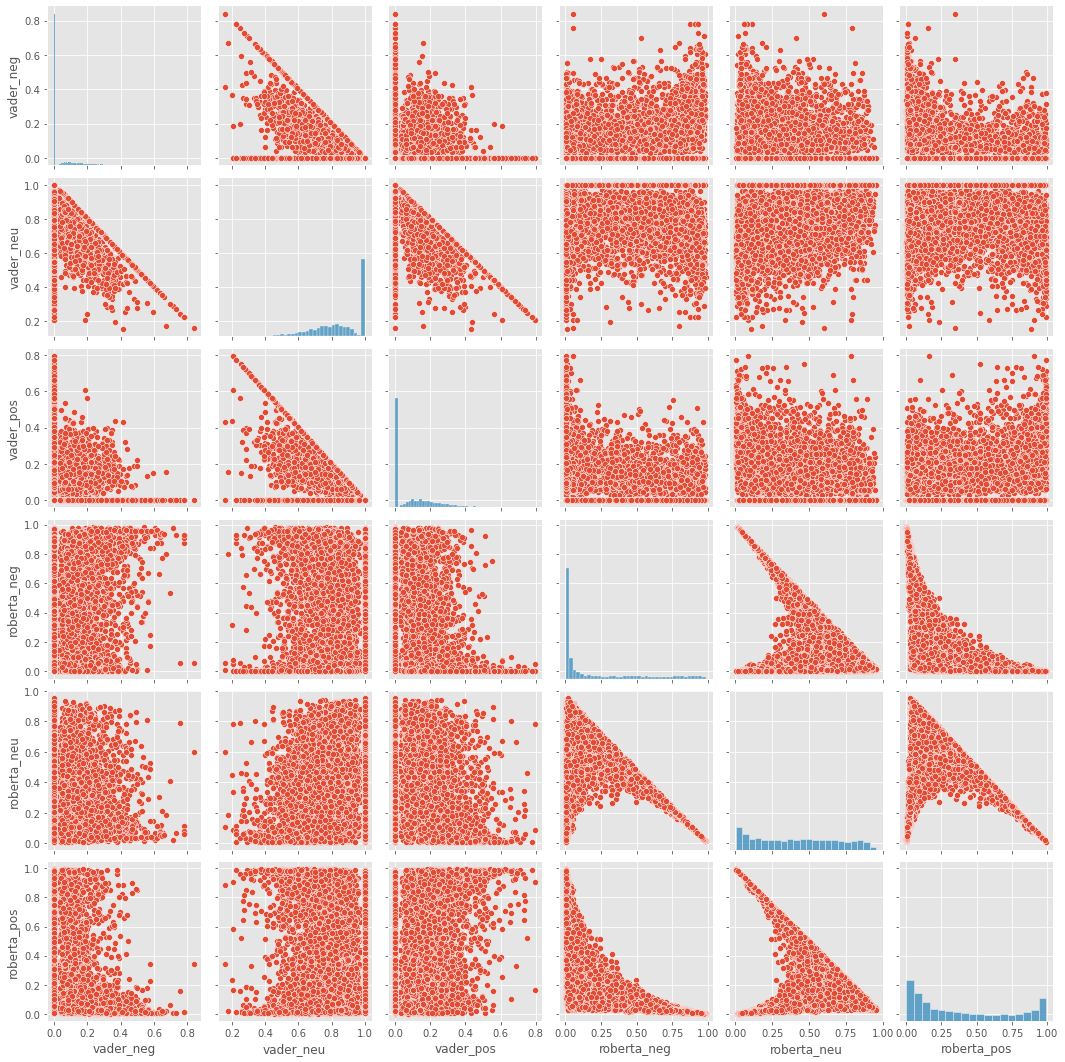

In [178]:
# use pariplot to show the comparation 
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            # hue='Score',
            palette='tab10')
plt.show()

**_Analysis_** 

Difficult to see if there's correlation, but roBERTa model is more confident in its prediction. 